# README
- This notebook follows closely the blog post **[Fine-Tuning Gemma Models in Hugging Face](https://huggingface.co/blog/gemma-peft)**. 
- The goal is to get familiar with the fine-tuning of [Gemma](https://github.com/google-deepmind/gemma), an open weights language model from Google Deepmind, 2 billion parameter version. 
- The data is taken from the **VoxPopuli** dataset. Following standard guidelines, only a small subset of the data is taken to get familiar with the pipeline.
- Main author: Tillman Heisner
- Contributors: Erik Bode, Tilman Rosenlicht

# Install the dependecies

In [ ]:
run_local = False
run_on_kaggle = True
use_entire_dataset = False
use_vp = False

if not run_local:
    !pip install huggingface_hub
    !pip install datasets
    !pip install transformers
    !pip install bitsandbytes
    !pip install accelerate
    !pip install peft
    !pip install torch
    !pip install trl
    !pip install evaluate
    !pip install rouge_score
    !pip install mauve-text

In [ ]:
num_training_samples = 50000
num_validation_samples = 1750
output_model_name = "grid_search_cv_r1"

In [ ]:
if run_local:
    if use_vp:
        output_path = "kaggle/working/" + output_model_name
        dataset_path = "kaggle/input/vp_txt.hf"
    else:
        output_path = "kaggle/working/" + output_model_name
        dataset_path = "kaggle/input/cv_13_en_txt.hf"
    working_dir = "kaggle/working/temp_data_sets/"
else:
    if use_vp:
        output_path = "/kaggle/working/" + output_model_name
        dataset_path = "/kaggle/input/vp_txt.hf"
    else:
        output_path = "/kaggle/working/" + output_model_name
        dataset_path = "/kaggle/input/cv_13_en_txt.hf"
    working_dir = "/kaggle/working/temp_data_sets/"

if run_on_kaggle:
    use_ac = True
    if run_on_kaggle and use_ac:
        %config Completer.use_jedi = False

# 1. Login into the clients

In [ ]:
import wandb
import huggingface_hub


if run_local:
    import os
    from dotenv import load_dotenv

    load_dotenv()

    # TODO - write your own token here
    hf_token = os.getenv("HF_TOKEN")
    wandb_token = os.getenv("wandb_api_key")
    huggingface_hub.login(token=hf_token)

    # login into the clients
    wandb.login(key=wandb_token)
    huggingface_hub.login(token=hf_token)

else:
    if run_on_kaggle:
        # access the secrets
        from kaggle_secrets import UserSecretsClient

        user_secrets = UserSecretsClient()

        # fetch the tokens from secrets
        wandb_token = user_secrets.get_secret("wandb_api_key")
        hf_token = user_secrets.get_secret("HF_TOKEN")

        # login into the clients
        wandb.login(key=wandb_token)
        huggingface_hub.login(token=hf_token)
    else:
        from google.colab import userdata

        # get the token from the userdata
        hf_token = userdata.get("HF_TOKEN")
        wandb_token = userdata.get("wandb_api_key")

        # login into the clients
        wandb.login(key=wandb_token)
        huggingface_hub.login(token=hf_tokken)

# 3. Load the datasets

- VoxPopuli
> VoxPopuli is a large-scale multilingual speech corpus consisting of political data sourced from 2009-2020 European Parliament event recordings. The English subset contains approximately 550 hours of speech largely from non-native English speakers. It is licensed under CC0.
- CommonVoice
> Common Voice is a series of crowd-sourced open-licensed speech datasets where speakers record text from Wikipedia in various languages. The speakers are of various nationalities and native languages, with different accents and recording conditions. We use the English subset of version 9.0 (27-4-2022), with approximately 1,400 hours of audio-transcription data. It is licensed under CC0-1.0.

| Dataset     | Source               | Type      | Hours | Languages | Accents | Text Format         | License  |
|-------------|-----------------------|-----------|-------|-----------|---------|----------------------|----------|
| Common Voice| Wikipedia, Narrated   | Narrated  | 1409  | 27        | 27      | Punctuated & Cased   | CC0-1.0  |
| Voxpopuli   | European Parliament   | Oratory   | 523   | 5         | 5       | Punctuated           | CC0      |

Source: https://huggingface.co/datasets/esb/datasets

In [ ]:
from datasets import load_dataset, load_from_disk

data = load_from_disk(dataset_path)
if use_entire_dataset:
    data_train = data["train"]
    data_validation = data["validation"]
    data_test = data["test"]
    num_training_samples = "all"
    num_validation_samples = "all"
else:
    data_train = data["train"].select(range(num_training_samples))
    data_validation = data["validation"].select(range(num_validation_samples))
    data_test = data["test"]

# 4. Load the LoRA config


> Low-Rank Adaptation for Large Language Models
> 
> Low-Rank Adaptation (LoRA) is one of the parameter-efficient fine-tuning techniques for large language models (LLMs). It addresses just a fraction of the total number of model parameters to be fine-tuned, by freezing the original model and only training adapter layers that are decomposed into low-rank matrices. The PEFT library provides an easy abstraction that allows users to select the model layers where adapter weights should be applied
>
> In this snippet, we refer to all nn.Linear layers as the target layers to be adapted.
> 
> In the following example, we will leverage QLoRA, from Dettmers et al., in order to quantize the base model in 4-bit precision for a more memory efficient fine-tuning protocol. The model can be loaded with QLoRA by first installing the bitsandbytes library on your environment, and then passing a BitsAndBytesConfig object to from_pretrained when loading the model.

Source: https://huggingface.co/blog/gemma-peft

In [ ]:
from peft import LoraConfig

lora_config = LoraConfig(
    r=8,
    target_modules=[
        "q_proj",
        "o_proj",
        "k_proj",
        "v_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
    ],
    task_type="CAUSAL_LM",
)

# 5. Load the model and tokenizer

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

model_id = "google/gemma-2b"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained(
    model_id, token=hf_token, padding_side="right"
)
model = AutoModelForCausalLM.from_pretrained(
    model_id, quantization_config=bnb_config, device_map={"": 0}, token=hf_token
)

# 6. Tokenize the datasplits

In [ ]:
if run_local:
    !rm -rf "kaggle/working/temp_data_sets"
    !mkdir "kaggle/working/temp_data_sets"
else:
    !rm -rf "/kaggle/working/temp_data_sets"
    !mkdir "/kaggle/working/temp_data_sets"

In [ ]:
if use_vp:
    text_field = "text"
else:
    text_field = "sentence"


def tokenize_and_cache(data, tokenizer, max_length, cache_file_name):
    return data.map(
        lambda examples: tokenizer(
            examples[text_field],
            padding="max_length",
            truncation=True,
            max_length=max_length,
            return_attention_mask=True,
            return_tensors="pt",
        ),
        batched=True,
        cache_file_name=cache_file_name,
    )

In [ ]:
max_length = 16

# Paths to cache files
working_dir = "./"
if use_vp:
    train_cache = working_dir + "vp_train.cache"
    val_cache = working_dir + "vp_valid.cache"
    test_cache = working_dir + "vp_test.cache"
else:
    train_cache = working_dir + "cv13_train.cache"
    val_cache = working_dir + "cv13_valid.cache"
    test_cache = working_dir + "cv13_test.cache"

# Tokenize and cache
train_data = tokenize_and_cache(data_train, tokenizer, max_length, train_cache)
val_data = tokenize_and_cache(data_validation, tokenizer, max_length, val_cache)
test_data = tokenize_and_cache(data_test, tokenizer, max_length, test_cache)

# 7.1 Specify the SFTConfig

## [Gradient accumulation](https://medium.com/@harshit158/gradient-accumulation-307de7599e87)
 Gradient accumulation is a valuable technique for training neural networks under memory constraints, allowing for larger effective batch sizes and potentially more stable training.

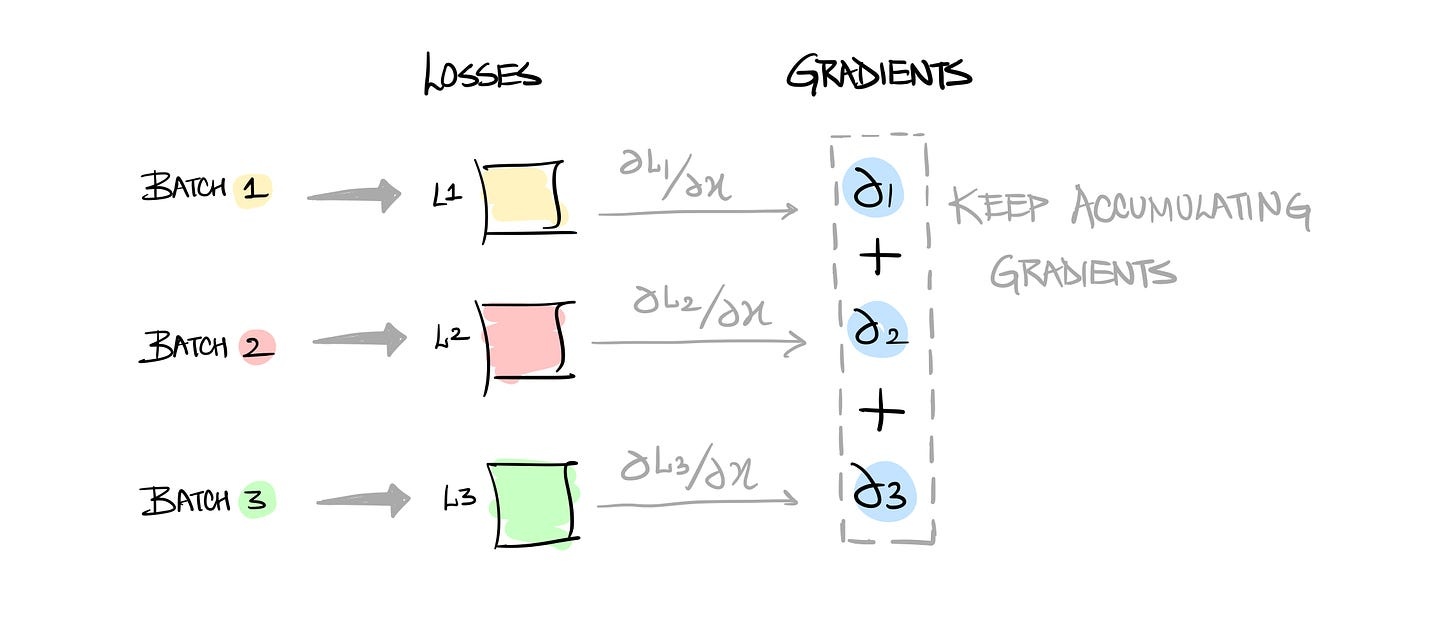

### No information was found if normalization is done by the huggingface implementation!!!

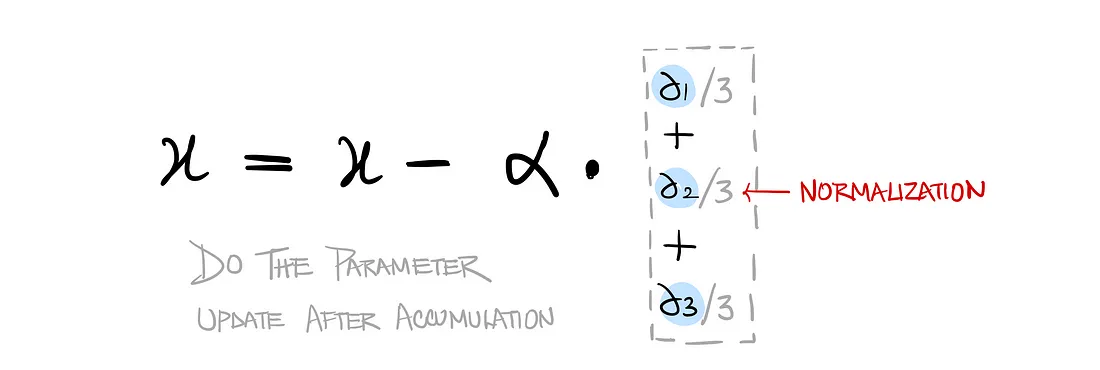

### If you set gradient_accumulation_steps to 4, the process would look like this:

- Step 1: Compute gradients for the first mini-batch and store them.
- Step 2: Compute gradients for the second mini-batch and add them to the stored gradients.
- Step 3: Compute gradients for the third mini-batch and add them to the stored gradients.
- Step 4: Compute gradients for the fourth mini-batch, add them to the stored gradients, and then update the model parameters using the accumulated gradients.

This approach allows you to simulate a larger batch size, which can help stabilize training and improve memory efficiency.

#### Benefits

- Memory Efficiency: Allows training with larger effective batch sizes without exceeding GPU memory limits.
- Stabilized Training: Reduces the noise in gradient updates, which can lead to more stable and potentially better training outcomes.
- Flexibility: Enables training large models on hardware with limited memory.

### Considerations

- Training Time: While gradient accumulation can help with memory constraints, it may lead to slightly longer training times since weight updates are performed less frequently.
- Implementation: Ensure that the optimizer and other training components are correctly configured to handle accumulated gradients.


---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
## [Warmup Steps](https://datascience.stackexchange.com/questions/55991/in-the-context-of-deep-learning-what-is-training-warmup-steps)

Warmup steps are a technique used in the training of machine learning models, particularly in the context of learning rate scheduling. The primary purpose of warmup steps is to gradually increase the learning rate from a very low value to the desired learning rate over a specified number of initial training steps. This helps to stabilize the training process and prevent large, destabilizing updates to the model parameters early in training.
How Warmup Steps Work

- Initial Phase: During the warmup phase, the learning rate starts at a very low value and increases linearly (or according to another schedule) to the target learning rate.
- Post-Warmup Phase: After the warmup steps are completed, the learning rate follows the specified learning rate schedule (e.g., constant, linear decay, cosine decay).

### Benefits of Warmup Steps

- Stabilization: Helps to stabilize the training process by preventing large updates to the model parameters at the beginning of training.
- Improved Convergence: Can lead to better convergence properties by allowing the optimizer to start with small steps and gradually increase the step size.
- Adaptive Optimizers: Particularly useful for adaptive optimizers like Adam or RMSProp, which rely on accurate gradient statistics that can be skewed by large initial updates.

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
## [FP16 (Half Precision)](https://medium.com/@furkangozukara/what-is-the-difference-between-fp16-and-bf16-here-a-good-explanation-for-you-d75ac7ec30fa)
In the SFTConfig, **fp16=True** enables mixed precision training using 16-bit floating point (FP16) arithmetic. Here are the key points about FP16 in this context:

- Precision: FP16 uses 16 bits to represent floating-point numbers, compared to the standard 32-bit (FP32) representation.
- Memory Efficiency: Using FP16 can significantly reduce memory usage, allowing for larger batch sizes or model sizes on the same hardware.
- Speed: FP16 computations can be faster on modern GPUs, particularly those with dedicated hardware support for FP16 operations.

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
## [AdamW](https://arxiv.org/abs/1711.05101)

The AdamW optimizer is a variant of the Adam optimizer that incorporates weight decay directly into the parameter updates, rather than modifying the gradients. This approach helps to decouple the weight decay from the gradient updates, leading to better regularization and improved training stability.

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
## [8 Bit Optimizers](https://huggingface.co/docs/bitsandbytes/main/en/optimizers)

8-bit optimizers are a class of optimization algorithms designed to reduce memory consumption and improve computational efficiency by using 8-bit precision for certain parameters. 

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# References
- Pictures are taken from this [post](https://medium.com/@harshit158/gradient-accumulation-307de7599e87)
- Explanations were created with the help of [perplexity 
](https://www.perplexity.ai)

In [ ]:
from trl import SFTConfig

num_devices = torch.cuda.device_count()

# define parameters
max_seq_length = max_length
gradient_accumulation_steps = 4
warmup_steps = 2
learning_rate = 2e-4
fp16 = True
optim = "paged_adamw_8bit"
evaluation_strategy = "steps"
eval_steps = 10
num_train_epochs = 100
batch_size = 32
logging_steps = 1
save_strategy = "steps"
save_steps = 10
hub_strategy = "every_save"
push_to_hub = True
hub_token = hf_token
hub_private_repo = True
metric_for_best_model = "eval_loss"
# greater_is_better=False # will default to False if you use eval_loss for metric for best model
load_best_model_at_end = True
lr_scheduler_type = "cosine"


sft_config = SFTConfig(
    max_seq_length=max_seq_length,
    gradient_accumulation_steps=gradient_accumulation_steps,
    warmup_steps=warmup_steps,
    learning_rate=learning_rate,
    fp16=fp16,
    optim=optim,
    eval_strategy=evaluation_strategy,
    eval_steps=eval_steps,  # during real training, set to reasonable number. for debugging, prints every time
    per_device_train_batch_size=batch_size,
    num_train_epochs=num_train_epochs,
    logging_steps=logging_steps,
    output_dir=output_path,
    report_to="wandb",
    save_strategy=save_strategy,
    save_steps=save_steps,
    hub_strategy=hub_strategy,
    push_to_hub=push_to_hub,
    hub_token=hub_token,
    hub_private_repo=True,
    metric_for_best_model=metric_for_best_model,
    load_best_model_at_end=load_best_model_at_end,
    lr_scheduler_type=lr_scheduler_type,
)

In [ ]:
from transformers.trainer_callback import EarlyStoppingCallback

early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=5,  # Number of evaluations with no improvement after which training will be stopped
    early_stopping_threshold=0.01,  # Minimum change to qualify as an improvement
)

# 7.2 Initiliaze wandb

In [ ]:
if use_vp:
    dataset = "VoxPopuli"
else:
    dataset = "CommonVoice"
config = {
    "max_seq_lentgh": max_seq_length,
    "gradient_accumulation_steps": gradient_accumulation_steps,
    "warmup_steps": warmup_steps,
    "learning_rate": learning_rate,
    "fp16": fp16,
    "optim": optim,
    "eval_strategy": evaluation_strategy,
    "per_device_train_batch_size": batch_size,
    "num_train_epochs": num_train_epochs,
    "logging_steps": logging_steps,
    "dataset": dataset,
    "Training samples used": num_training_samples,
    "Validation samples used": num_validation_samples,
    "project": "gemma2b_identifying_opinions_in_informative_text",
    "experiment_name": output_model_name,
    "learning_rate_scheduler": lr_scheduler_type,
}
wandb.init(config=config, project=config["project"], name=config["experiment_name"])

# 7.3 Define the evaluation metrics
## [Bleu](https://huggingface.co/spaces/evaluate-metric/bleu): 
> ### Bilingual Evaluation Understudy is an algorithm for evaluating the quality of text which has been machine-translated from one natural language to another.
## [Rogue](https://huggingface.co/spaces/evaluate-metric/rouge):
> ### Recall-Oriented Understudy for Gisting Evaluation, is a set of metrics and a software package used for evaluating automatic summarization and machine translation software in natural language processing
## [Meteor](https://huggingface.co/spaces/evaluate-metric/meteor):
> ### Automatic metric for machine translation evaluation that is based on a generalized concept of unigram matching between the machine-produced translation and human-produced reference translations
## [MAUVE](https://huggingface.co/spaces/evaluate-metric/mauve):
> ###  Measure of the statistical gap between two text distributions, e.g., how far the text written by a model is the distribution of human text, using samples from both distributions.
## [Perplexity](https://huggingface.co/spaces/evaluate-metric/perplexity)
> ### One of the most common metrics for evaluating language models. It is defined as the exponentiated average negative log-likelihood of a sequence, calculated with exponent base e

In [ ]:
import evaluate
import numpy as np

metric_functions = {
    # 'bleu': evaluate.load("bleu"),
    # 'rogue': evaluate.load("rouge"),
    # 'meteor': evaluate.load('meteor'), # TODO maybe add
    "mauve": evaluate.load("mauve"),  # Needs atleast 78 points!!!
    "perplexity": evaluate.load("perplexity", module_type="metric", hf_token=hf_token),
}


def preprocess_logits_for_metrics(logits, labels):
    return logits.argmax(axis=-1)


def compute_metrics(eval_preds):
    results = {}
    predictions, labels = eval_preds

    # -100 is typically used as a placeholder for padding or ignored tokens
    # and as we can not decode them we remove them
    preds = np.where(predictions != -100, predictions, tokenizer.pad_token_id)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

    # Decode predictions and labels
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Compute each metric
    for metric_name, metric_function in metric_functions.items():
        if metric_name == "perplexity":
            metric_result = metric_function.compute(
                model_id="google/gemma-2b",
                add_start_token=False,
                predictions=decoded_preds,
            )
        else:
            metric_result = metric_function.compute(
                predictions=decoded_preds, references=decoded_labels
            )
        # For BLEU score or other single scalar metrics, adapt the key - TODO do we want more from the metric?
        if metric_name == "bleu":
            results[f"{metric_name} score"] = metric_result[f"{metric_name}"]
        elif metric_name == "mauve":
            results[f"{metric_name} score"] = metric_result.mauve
        elif metric_name == "perplexity":
            results["mean perplexity score"] = metric_result["mean_perplexity"]
        elif metric_name == "rogue":
            results.update(metric_result)
    return results

# 7.4 Construct the trainer




In [ ]:
# callback for custom sampling - to be used in the trainer
# see arg of  SFTTrainer https://huggingface.co/docs/trl/sft_trainer


def sample_model(model, tokenizer, prompt, max_length=None):
    """
    Simple function to sample from the model for given prompts.
    Tries to generate text of similar length as the prompt.

    Args:
        model: The model to sample from
        tokenizer: The tokenizer to use
        prompt: The prompt to sample from
        max_length: The maximum length of the generated text
    """
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    # get the length of the prompt
    if max_length is None:
        max_length = inputs["input_ids"].shape[-1] + 2
    # halve the prompt to make the model actually generate
    prompt_short = prompt[: len(prompt) // 2]
    # new embedding of the prompt
    inputs = tokenizer(prompt_short, return_tensors="pt").to(model.device)
    with torch.no_grad():
        outputs = model.generate(
            **inputs, max_length=max_length, num_return_sequences=1
        )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)


def custom_evaluation(model, tokenizer, prompts):
    """
    Wrapper function to sample from the model for given prompts.

    Args:
        model: The model to sample from
        tokenizer: The tokenizer to use
        prompts: The prompts to sample from
    """
    samples = [sample_model(model, tokenizer, prompt) for prompt in prompts]
    return {"samples": samples}


from transformers import TrainerCallback


class SamplingCallback(TrainerCallback):
    """
    Callback to sample from the model during evaluation.
    see https://huggingface.co/docs/transformers/main_classes/callback#transformers.TrainerCallback for more information
    Args:
        tokenizer: The tokenizer to use
        prompts: (optional) The prompts to sample from  - if None, default prompts are used
            Prompts should be a list of strings.
    """

    def __init__(self, tokenizer, prompts=None):
        self.tokenizer = tokenizer
        self.prompts = prompts

    def on_evaluate(
        self, args, state, control, model, **kwargs
    ):  # function to be called after evaluation phase
        """
        This function performs the sampling from the model and prints the results.
        """
        if self.prompts is None:
            prompts = [
                "if you do not address this problem the ground is there for populist nationalist forces to go on growing all over europe.",
                "Trump trial judge admonishes ‘eye-rolling’ defence witness",
            ]
        samples = custom_evaluation(model, self.tokenizer, prompts)
        print(f"Samples at step {state.global_step}:")
        # debugging: print prompt and prediction
        for i, (prompt, sample) in enumerate(zip(prompts, samples["samples"])):
            print(f"=============== Sampling prompt {i} ===============")
            print(f"Prompt: {prompt}")
            print(f"Sample: {sample}")
            print("\n")

In [ ]:
from trl import SFTTrainer


trainer = SFTTrainer(
    model=model,
    train_dataset=train_data,
    eval_dataset=val_data,
    args=sft_config,
    peft_config=lora_config,
    tokenizer=tokenizer,
    callbacks=[early_stopping_callback],
    # compute_metrics=compute_metrics,
    # preprocess_logits_for_metrics=preprocess_logits_for_metrics,
    # callbacks=[SamplingCallback(tokenizer)],
)

# 8. Run the training

In [ ]:
trainer.train()

In [ ]:
trainer.push_to_hub()

# *. Load FSDP config - [Example](http://https://huggingface.co/google/gemma-7b/blob/main/examples/example_fsdp.py)

> Hugging Face transformers now supports PyTorch/XLA’s latest FSDP implementation. This can greatly accelerate the fine-tuning speed. To enable that, one just needs to add a FSDP config to the transformers.Trainer.

Source: https://huggingface.co/blog/gemma-peft